In [1]:
import numpy as np
from astropy.modeling.models import Sersic2D
import matplotlib.pyplot as plt

In [2]:
x,y = np.meshgrid(np.arange(100), np.arange(100))

mod = Sersic2D(amplitude = 1, r_eff = 25, n=4, x_0=50, y_0=50,
               ellip=.5, theta=-1)
img = mod(x, y)
log_img = np.log10(img)

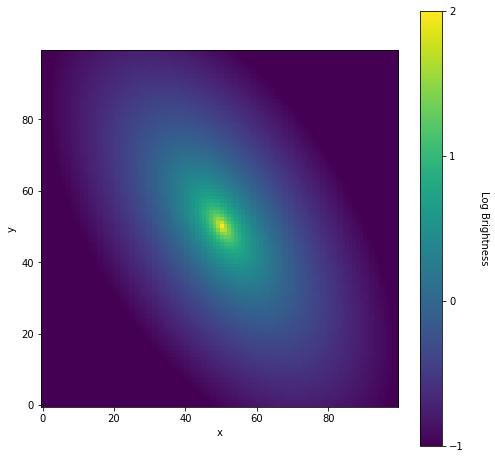

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(log_img, origin='lower', interpolation='nearest',
           vmin=-1, vmax=2)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

In [43]:
from astropy import units as u
from astropy.units import Quantity, UnitsError
from astropy.utils.decorators import deprecated
from astropy.modeling.core import (Fittable1DModel, Fittable2DModel,
                                   ModelDefinitionError)

from astropy.modeling.parameters import Parameter, InputParameterError
from astropy.modeling.utils import ellipse_extent


class VelField(Fittable2DModel):

    i = Parameter(default=45)
    phi = Parameter(default=0)
    Vmax = Parameter(default=100)
    rd = Parameter(default=1)
    x0 = Parameter(default=0)
    y0 = Parameter(default=0)
    V0 = Parameter(default=0)
    alpha = Parameter(default=5)
    @classmethod
    def evaluate(cls, x, y, i, phi, Vmax, rd, x0, y0, V0, alpha):
        """
        TODO: angle in units and accept them accordingly
        TODO: Be consistent with Sersic2D
        (x,y) kartesian sky coordinates, 
        (x0,y0) kartesian sky coordiantes of rotation centre of galaxy,
        V0 velocity of centre wrt observer, 
        i inclination angle between the normal to the galaxy plane and the line-of-sight,
        phi position angle of the major axis wrt to north (=up) measured counterclockwise,
        Vmax constant rotation for R>>rd, 
        rd scale length of galaxy (assumed to be turnover radius) 
        """
        phi = phi * np.pi/180  
        i = i * np.pi/180
        r = ((x - x0)**2 + (y - y0)**2)**0.5
        cost = (-(x - x0)*np.sin(phi) + (y - y0)*np.cos(phi)) / (r + 0.00001)	#cos(theta)=cost= azimuthal angle in the plane of the galaxy
        #sint=(-(x-x0)*np.cos(phi)+(y-y0)*np.sin(phi))/(R*np.cos(i))
    #    Vr = Vmax*(R - R0)*((R - R0)**alpha + rd**alpha)**(-1.0/alpha)	#e.g. Courteau 1997
        
        Vr = Vmax*r / (r**alpha + rd**alpha)**(1/alpha)
        #Vr = Vmax*2/np.pi*np.arctan( r/rd)         #arctan model
        return V0 + Vr*np.sin(i)*cost
    
    @property
    def input_units(self):
        if self.x0.unit is None:
            return None
        else:
            return {'x': self.x0.unit,
                    'y': self.y0.unit}

    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        # Note that here we need to make sure that x and y are in the same
        # units otherwise this can lead to issues since rotation is not well
        # defined.
        if inputs_unit['x'] != inputs_unit['y']:
            raise UnitsError("Units of 'x' and 'y' inputs should match")
        return {'x0': inputs_unit['x'],
                'y0': inputs_unit['x'],
                'rd': inputs_unit['x'],
                'phi': u.deg,
                'amplitude': outputs_unit['z']}

In [44]:
x,y = np.meshgrid(np.arange(100), np.arange(100))
mod = VelField( rd = 15, x0=50, y0=50, i=45, phi=45, alpha=5)
img = mod(x, y)
#log_img = np.log10(img)

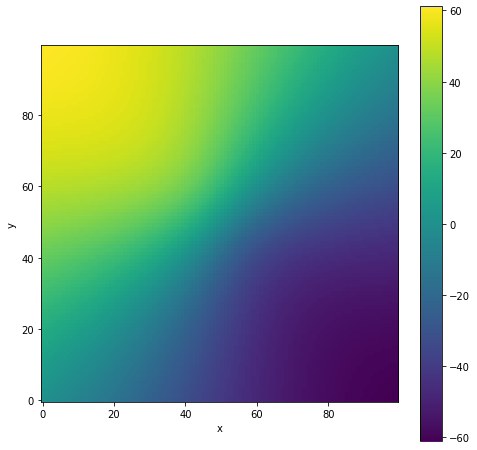

In [45]:
plt.figure(figsize=(8,8))
plt.imshow(img, origin='lower', interpolation='nearest')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
plt.show()